In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
import jax.random as jax_random
import pandas as pd

import keras
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import ops

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader

In [3]:
plt.set_loglevel("info")

In [4]:
print(f"Keras: {keras.__version__}")

Keras: 3.6.0


In [5]:
VERBOSE = 0

In [6]:
epochs = 50  # 50 epochs of training
B = 256  # a respectable average batch size

to_numpy_array = lambda img: np.array(img, dtype=np.float32) / 255.0

train_data = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=to_numpy_array, download=True
)
test_data = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=to_numpy_array, download=True
)

train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

In [7]:
eta_0 = 0.1

# How many values are in the input? We use this to help determine the size of subsequent layers
D = 28 * 28  # 28 * 28 images
# Hidden layer size
n = 128
# How many channels are in the input?
C = 1
# How many classes are there?
classes = 10


def get_fc_model():
    return models.Sequential(
        [
            layers.Input(shape=(28, 28)),
            layers.Flatten(),
            layers.Dense(n, activation="tanh"),
            layers.Dense(n, activation="tanh"),
            layers.Dense(n, activation="tanh"),
            layers.Dense(classes, activation="softmax"),
        ]
    )


fc_model = get_fc_model()

fc_model.compile(
    optimizer=optimizers.SGD(learning_rate=eta_0),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [8]:
fc_model_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=VERBOSE
)

<Axes: >

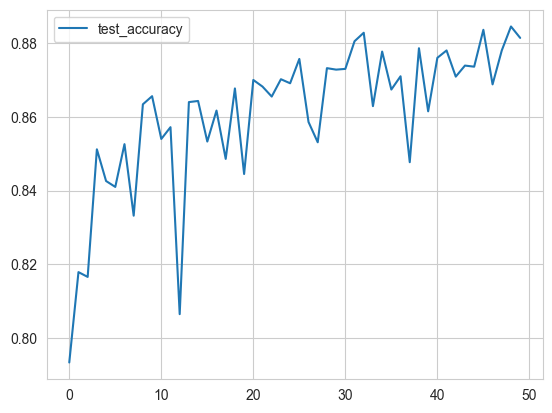

In [9]:
pd.DataFrame(
    {"test_accuracy": fc_model_result.history["val_sparse_categorical_accuracy"]}
).plot()

0.954992586021436


Text(0, 0.5, 'Learning Rate')

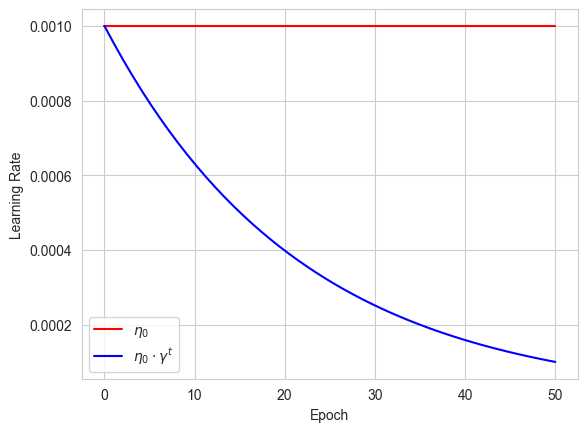

In [10]:
T = 50  # total epochs
epochs_input = np.linspace(0, 50, num=50)  # generating all of the different t values
eta_init = 0.001  # pretend initial learning rate $\eta_0$
eta_min = 0.0001  # pretend desired minimum learning rate $\eta_{\mathit{min}}$
gamma = np.power(eta_min / eta_init, 1.0 / T)  # Compute the decay rate $\gamma$
print(gamma)
effective_learning_rate = eta_init * np.power(
    gamma, epochs_input
)  # all of the $\eta_t$ values

sns.lineplot(x=epochs_input, y=eta_init, color="red", label="$\\eta_0$")
ax = sns.lineplot(
    x=epochs_input,
    y=effective_learning_rate,
    color="blue",
    label="$\\eta_0 \\cdot \\gamma^t$",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")

In [11]:
fc_model = get_fc_model()

eta_min = 0.0001  # Our desired final learning rate $\eta_{\mathit{min}}$

gamma_expo = (eta_min / eta_0) ** (
    1 / epochs
)  # compute $\gamma$ that results in $\eta_{\mathit{min}}$

scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=eta_0, decay_rate=gamma, decay_steps=T, staircase=True
)
optimizer = optimizers.SGD(learning_rate=scheduler)  # Set up the optimizer
# train like normal and pass along the desired optimizer and schedule

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_expo_decay_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=VERBOSE
)

In [12]:
print(gamma_expo)

0.8709635899560806


Text(0, 0.5, 'Learning Rate')

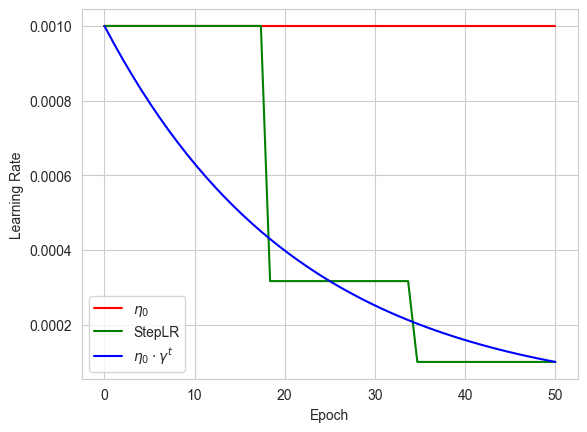

In [25]:
sns.lineplot(x=epochs_input, y=eta_init, color="red", label="$\\eta_0$")
sns.lineplot(
    x=epochs_input,
    y=[eta_init] * 18 + [eta_init / 3.16] * 16 + [eta_init / 10] * 16,
    color="green",
    label="StepLR",
)
ax = sns.lineplot(
    x=epochs_input,
    y=effective_learning_rate,
    color="blue",
    label="$\\eta_0 \\cdot \\gamma^t$",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")

In [14]:
fc_model = get_fc_model()

values = list(
    sorted(set([eta_init] * 18 + [eta_init / 3.16] * 16 + [eta_init / 10] * 16))
) + [0.001]
boundaries = [18, 18 + 16, 18 + 16 * 2]
scheduler = optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries, values=values
)
optimizer = optimizers.SGD(learning_rate=scheduler)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_steplr_decay_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=VERBOSE
)

In [15]:
list(sorted(set([eta_init] * 18 + [eta_init / 3.16] * 16 + [eta_init / 10] * 16)))

[0.0001, 0.00031645569620253165, 0.001]

Text(0, 0.5, 'Learning Rate')

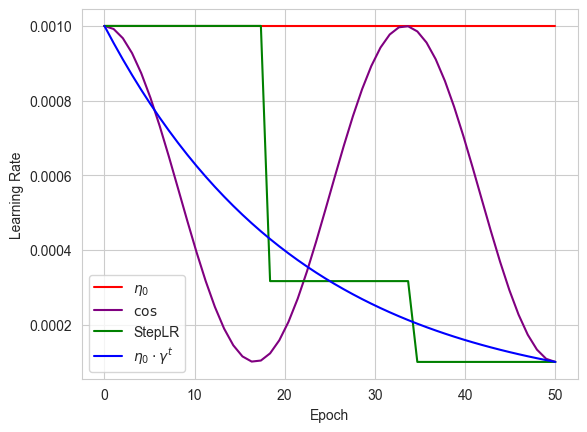

In [16]:
cos_lr = eta_min + 0.5 * (eta_init - eta_min) * (
    1 + np.cos(epochs_input / (T / 3.0) * np.pi)
)  # computes the cosine schedule $\eta_t$ for every value of $t$

sns.lineplot(x=epochs_input, y=eta_init, color="red", label="$\\eta_0$")
sns.lineplot(x=epochs_input, y=cos_lr, color="purple", label="$\\cos$")
sns.lineplot(
    x=epochs_input,
    y=[eta_init] * 18 + [eta_init / 3.16] * 16 + [eta_init / 10] * 16,
    color="green",
    label="StepLR",
)
ax = sns.lineplot(
    x=epochs_input,
    y=effective_learning_rate,
    color="blue",
    label="$\\eta_0 \\cdot \\gamma^t$",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")

In [17]:
fc_model = get_fc_model()

decay_steps = 50 / 3
initial_learning_rate = 1.0
scheduler = optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, alpha=1e-4
)

optimizer = optimizers.SGD(learning_rate=scheduler)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_cosine_decay_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=VERBOSE
)

<Axes: >

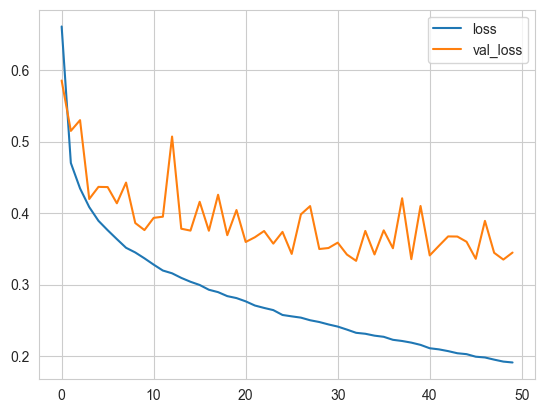

In [18]:
pd.DataFrame(fc_model_result.history)[["loss", "val_loss"]].plot()

In [19]:
fc_model = get_fc_model()

optimizer = optimizers.SGD(learning_rate=eta_0)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10)
fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_reducelr_result = fc_model.fit(
    train_loader,
    epochs=epochs,
    validation_data=test_loader,
    callbacks=reduce_lr,
    verbose=VERBOSE,
)

# SGD vs SGD Momentum, Nesterov Momentum

In [20]:
fc_model = get_fc_model()

optimizer = optimizers.SGD(learning_rate=1e-1, momentum=0.9, nesterov=False)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_momentum_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=VERBOSE
)

In [21]:
fc_model = get_fc_model()

optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_nesterov_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=VERBOSE
)

<Axes: >

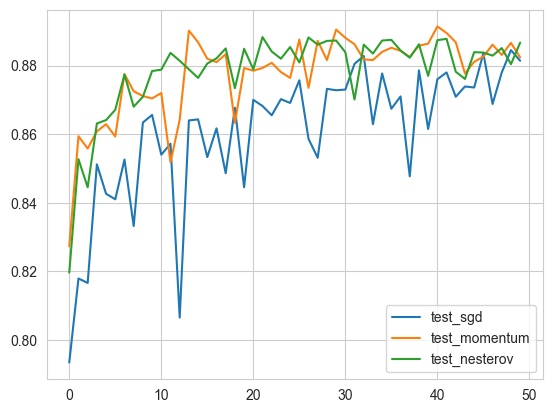

In [22]:
pd.DataFrame(
    {
        "test_sgd": fc_model_result.history["val_sparse_categorical_accuracy"],
        "test_momentum": fc_model_momentum_result.history[
            "val_sparse_categorical_accuracy"
        ],
        "test_nesterov": fc_model_nesterov_result.history[
            "val_sparse_categorical_accuracy"
        ],
    }
).plot()

In [23]:
fc_model = get_fc_model()

optimizer = optimizers.AdamW()

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_adamw_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=VERBOSE
)

<Axes: >

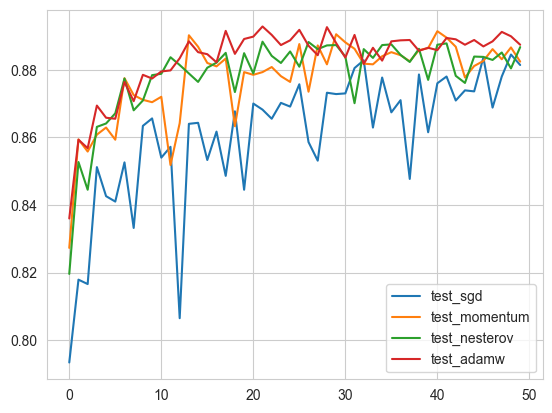

In [24]:
pd.DataFrame(
    {
        "test_sgd": fc_model_result.history["val_sparse_categorical_accuracy"],
        "test_momentum": fc_model_momentum_result.history[
            "val_sparse_categorical_accuracy"
        ],
        "test_nesterov": fc_model_nesterov_result.history[
            "val_sparse_categorical_accuracy"
        ],
        "test_adamw": fc_model_adamw_result.history["val_sparse_categorical_accuracy"],
    }
).plot()